In [1]:
import os.path as osp
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import json
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def get_pc(img, depth, cam_info):
    """ Returns a point cloud with colors from an image and depth map
    
    Args:
        img: A numpy array representing an image (H, W, 3)
        depth: A numpy array representing a depth map (N, 3) [(x_coords, y_coords, z_depths), ...]
        cam_info: A list of camera parameters [fx, fy, cx, cy, ...]
    """
    fx, fy, cx, cy, *_ = cam_info
    x_coord, y_coord, z_depth = depth.T
    
    # Convert pixel coordinates to camera coordinates
    x_cam = (x_coord - cx) * z_depth / fx   # -->(+) right
    y_cam = (y_coord - cy) * z_depth / fy   # -->(+) down
    z_cam = z_depth                         # -->(+) forward

    # Clip pixel coordinates to image bounds
    yc = np.clip(y_coord.astype(int), 0, img.shape[0]-1)
    xc = np.clip(x_coord.astype(int), 0, img.shape[1]-1)
    colors = img[yc, xc] / 255.0  # Normalize color values

    return (x_cam, y_cam, z_cam), colors


def show_depth_values_in_image(image, depth, radius=2, mod=20, cmap='hsv'):
    """ Show the depth values in the image

    Args:
        image: A numpy array representing an image (H, W, 3)
        depth: A numpy array representing a depth map (N, 3) [(x_coords, y_coords, z_depths), ...]
        radius: The radius of the square to draw around the depth point
        mod: The modulo value to apply to the depth values
        cmap: The colormap to use for the depth
    """
    coord_x, coord_y, dpt = depth.T
    coord_x = coord_x.astype(np.int32)
    coord_y = coord_y.astype(np.int32)

    dpt = dpt % mod
    normalizer = mpl.colors.Normalize(vmin=dpt.min(), vmax=dpt.max())
    mapper = cm.ScalarMappable(norm=normalizer, cmap=cmap)
    dpt = mapper.to_rgba(dpt)[:, :3]

    for i in range(1-radius, radius):
        for j in range(1-radius, radius):
            cx = coord_x+i
            cy = coord_y+j
            mask = (cx >= 0) & (cx < image.shape[1]) & (cy >= 0) & (cy < image.shape[0])
            image[cy[mask], cx[mask]] = (dpt[mask] * 255).astype(np.uint8)

    return image
    
    

## Visualize Point Clouds / Depth Annotations

../data_dir/waymo/val/segment-5372281728627437618_2005_000_2025_000/FRONT/rgb/original/000001.jpg
../data_dir/waymo/val/segment-5372281728627437618_2005_000_2025_000/FRONT/depth/000001.npy
../data_dir/waymo/val/segment-5372281728627437618_2005_000_2025_000/FRONT/rgb/cam.json


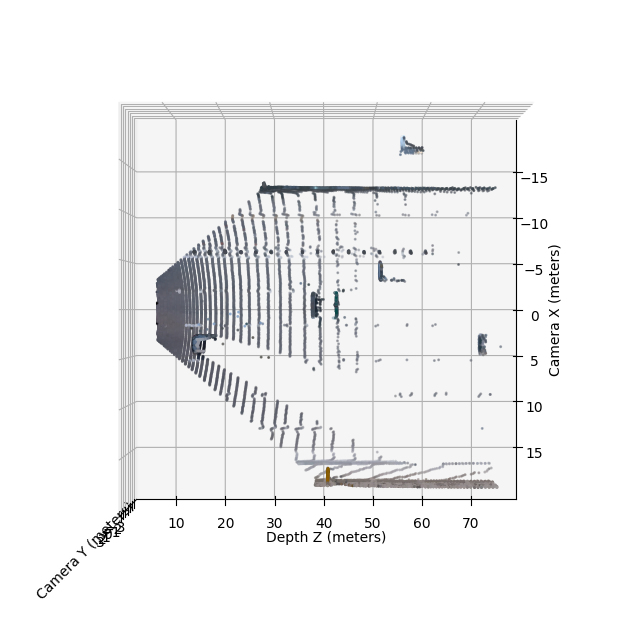

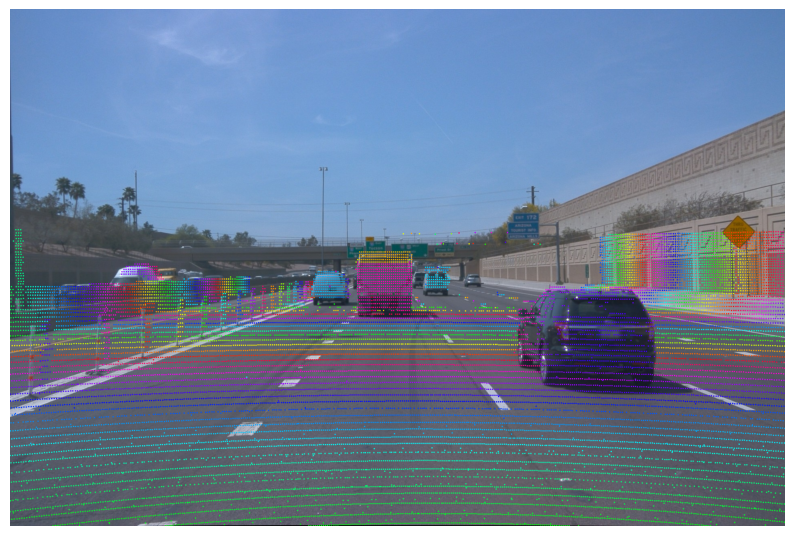

In [3]:
data_dir = '../data_dir/waymo'
split = 'val'
seg_name = 'segment-5372281728627437618_2005_000_2025_000'
frame_idx = 1

rgb_path = osp.join(data_dir, split, seg_name, 'FRONT/rgb/original/', f'{frame_idx:06}.jpg')
dpt_path = osp.join(data_dir, split, seg_name, 'FRONT/depth/', f'{frame_idx:06}.npy')
cam_path = osp.join(data_dir, split, seg_name, 'FRONT/rgb/cam.json')

for p in [rgb_path, dpt_path, cam_path]:
    print(p)
    assert osp.exists(p)

img = iio.imread(rgb_path)
depth = np.load(dpt_path)
with open(cam_path, 'r') as fh:
    cam = json.load(fh)['intrinsic']

(cam_x, cam_y, cam_z), colors = get_pc(img, depth, cam)

# Plot 3D point cloud
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(cam_x, cam_z, -cam_y, # Invert Y-axis to keep scene upright
                     c=colors, 
                     marker='.',
                     s=5)  # Point size

ax.set_xlabel('Camera X (meters)')
ax.set_ylabel('Depth Z (meters)')
ax.set_zlabel('Camera Y (meters)')
# ax.view_init(elev=45, azim=-45)   # Side view
ax.view_init(elev=90, azim=0)   # Top view
# plt.savefig('pc.pdf', dpi=2000, bbox_inches='tight')  # Save as PDF
plt.show()

depth_vis = show_depth_values_in_image(img.copy(), depth, radius=2, mod=20)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.imshow(depth_vis)
plt.axis('off')
plt.show()

## Compare Against Original LiDAR Point Clouds

### Loading Original LiDAR PC

In [4]:
import tensorflow as tf
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.utils import frame_utils

record_dir = '/share/hariharan/ys732/waymo/records/val'
record_path = osp.join(record_dir, f'{seg_name}_with_camera_labels.tfrecord')
assert osp.exists(record_path)
dataset = tf.data.TFRecordDataset(record_path, compression_type='')
for ii, data in enumerate(dataset):
    if ii == frame_idx:
        break

frame = open_dataset.Frame()
frame.ParseFromString(bytearray(data.numpy()))
cam_cal = {open_dataset.CameraName.Name.Name(cal.name) : cal for cal in frame.context.camera_calibrations}['FRONT']
range_images, camera_projections, _, range_image_top_pose = frame_utils.parse_range_image_and_camera_projection(frame)
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame, range_images, camera_projections, range_image_top_pose
)
lidar_points = np.concatenate(points, axis=0)

2025-01-02 17:30:54.690691: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-02 17:30:55.938151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11427 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:1a:00.0, compute capability: 6.1
2025-01-02 17:30:55.939128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11427 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:1b:00.0, compute capability: 6.1
2025-01-02 17:30:56.233616: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled

### Converting Cam PC into LiDAR Space

In [5]:
cam_points = np.array([cam_x, cam_y, cam_z]).T
extrinsic = np.array(cam_cal.extrinsic.transform).reshape(4, 4)
# (x front, y left, z up) -> (x right, y down, z front)
axis_swap = np.array([[0, 0, 1, 0], [-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
extrinsic = extrinsic @ axis_swap
cam_points2lidar = (extrinsic[:3, :3] @ cam_points.T + extrinsic[:3, 3:4]).T


### Plot Both

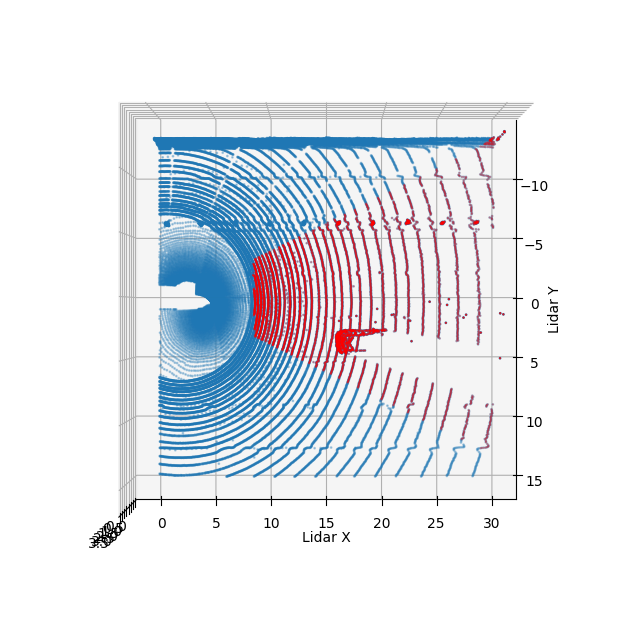

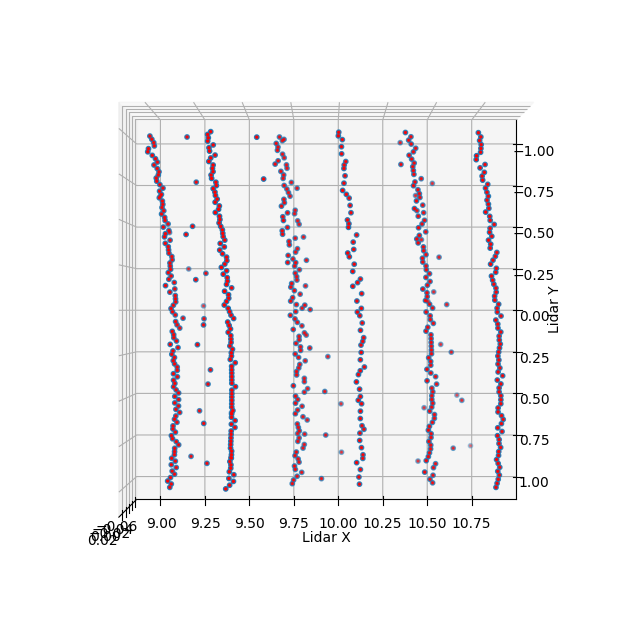

In [6]:
def plot_lidar_pc(ax, points_in_lidar_space, rng, **plot_kwargs):
    """ Plot a subset of the lidar point cloud

    Args:
        ax: The matplotlib axis to plot on
        points_in_lidar_space: A numpy array representing the lidar point cloud (N, 3)
        rng: A list of tuples representing the range of the lidar points [(x_min, x_max), (y_min, y_max)]
        plot_kwargs: Additional arguments to pass to the scatter plot function
    """
    lidar_x, lidar_y, lidar_z = points_in_lidar_space.T
    mask = (
        (lidar_x > rng[0][0])
        & (lidar_x < rng[0][1])
        & (lidar_y > rng[1][0])
        & (lidar_y < rng[1][1])
    )
    ax.scatter(-lidar_y[mask], lidar_x[mask], lidar_z[mask], **plot_kwargs) 


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
bound = [(0, 30), (-15, 15)]
plot_lidar_pc(ax, lidar_points, rng=bound, marker='o', s=1)
plot_lidar_pc(ax, cam_points2lidar, rng=bound, marker='.', c='r', s=1)
ax.set_xlabel('Lidar Y')
ax.set_ylabel('Lidar X')
ax.view_init(elev=90, azim=0)   # Top view
plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
bound = [(9, 11), (-1, 1)]
plot_lidar_pc(ax, lidar_points, rng=bound, marker='o', s=10)
plot_lidar_pc(ax, cam_points2lidar, rng=bound, marker='o', c='r', s=2)
ax.set_xlabel('Lidar Y')
ax.set_ylabel('Lidar X')
ax.view_init(elev=90, azim=0)   # Top view
plt.show()
